In [1]:
import torch,torchvision
from torchvision import transforms
from torch.multiprocessing import Pool, Process, set_start_method
from torch.optim import lr_scheduler

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    

try:
     set_start_method('spawn')
except RuntimeError:
    pass


In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

batch_size = 32

trainset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transform)

testset = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform=transform)

args = {
    "batch_size": batch_size,
    "shuffle": True,
    "num_workers": 0
}

split_args = {}

if torch.cuda.is_available():
    args["generator"] = torch.Generator(device='cuda')
    split_args["generator"] = torch.Generator(device='cuda')

test_set, val_set = torch.utils.data.random_split(
    testset, [5000, 5000], **split_args)



train_loader = torch.utils.data.DataLoader(trainset, **args)

test_loader = torch.utils.data.DataLoader(test_set, **args)
val_loader = torch.utils.data.DataLoader(val_set, **args)

dataloaders = {
    "train": train_loader,
    "test": test_loader,
    "val": val_loader
}


dataset_sizes = { x: len(dataloaders[x].dataset) for x in dataloaders}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_loader

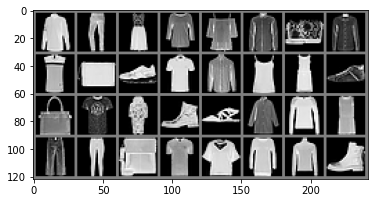

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders['train'])

images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels


In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
import time
import os
import copy

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    
    losses = {x:[] for x in ['train','val'] }


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')


    return model,losses

In [9]:
model_ft = net
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft,losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.2113 Acc: 0.5500
val Loss: 0.7150 Acc: 0.7368

Epoch 1/19
----------
train Loss: 0.6139 Acc: 0.7703
val Loss: 0.6135 Acc: 0.7686

Epoch 2/19
----------
train Loss: 0.5206 Acc: 0.8065
val Loss: 0.5546 Acc: 0.7852

Epoch 3/19
----------
train Loss: 0.4678 Acc: 0.8267
val Loss: 0.4764 Acc: 0.8276

Epoch 4/19
----------
train Loss: 0.4319 Acc: 0.8408
val Loss: 0.4509 Acc: 0.8332

Epoch 5/19
----------
train Loss: 0.4043 Acc: 0.8501
val Loss: 0.4277 Acc: 0.8416

Epoch 6/19
----------
train Loss: 0.3791 Acc: 0.8614
val Loss: 0.3962 Acc: 0.8528

Epoch 7/19
----------
train Loss: 0.3439 Acc: 0.8750
val Loss: 0.3796 Acc: 0.8660

Epoch 8/19
----------
train Loss: 0.3392 Acc: 0.8773
val Loss: 0.3770 Acc: 0.8664

Epoch 9/19
----------
train Loss: 0.3361 Acc: 0.8778
val Loss: 0.3757 Acc: 0.8650

Epoch 10/19
----------
train Loss: 0.3340 Acc: 0.8783
val Loss: 0.3734 Acc: 0.8668

Epoch 11/19
----------
train Loss: 0.3316 Acc: 0.8787
val Loss: 0.3709 Acc: 0.8668

Ep

In [11]:
losses

{'train': [1.2112628011862436,
  0.6138602316300075,
  0.5206059387763341,
  0.46780373264948527,
  0.4319281609137853,
  0.4043322077711423,
  0.37913721005121864,
  0.34387463332414625,
  0.3391813897271951,
  0.3360832712988059,
  0.33397795508305234,
  0.331618364516894,
  0.3294860239823659,
  0.32752257728377976,
  0.32286598931352295,
  0.32230031772057216,
  0.3220527034421762,
  0.32178467594385146,
  0.3215351650575797,
  0.3213597374022007],
 'val': [0.7150152498245239,
  0.6135439503669738,
  0.5546007112503052,
  0.476441966342926,
  0.4509247577190399,
  0.42765223565101623,
  0.39620415716171264,
  0.37957305846214295,
  0.3770076866388321,
  0.37572605633735656,
  0.37335556141138077,
  0.37090168676376345,
  0.36992295413017273,
  0.36855769891738893,
  0.3653359640181065,
  0.36491365203857423,
  0.3648537446975708,
  0.3652392988681793,
  0.3647999086141586,
  0.3648412947177887]}

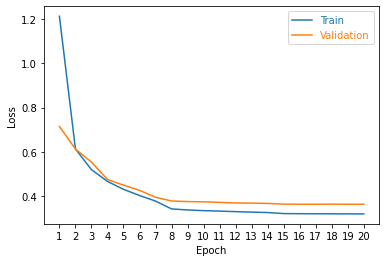

In [12]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt

host = host_subplot(111)


host.set_xlabel("Epoch")
host.set_ylabel("Loss")



plt.xticks(range(1,len(losses['train']) + 1 ) )

X = [i + 1 for i in range(len(losses['train']))]

p1, = host.plot(X, losses['train'], label="Train")
p2, = host.plot(X,losses['val'], label="Validation")



leg = plt.legend()

leg.texts[0].set_color(p1.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()

In [13]:
def test_model(model, criterion):

    # Each epoch has a training and validation phase

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)


    loss = running_loss / dataset_sizes['test']
    acc = running_corrects.double() / dataset_sizes['test']

    print(f'test Loss: {loss:.4f} Acc: {acc:.4f}')





In [14]:
test_model(model_ft, criterion)

test Loss: 0.3620 Acc: 0.8718


## Q2

In [15]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

NameError: name 'model_conv' is not defined

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.conv1.in_channels = 1
model.fc.out_features = 10
model.eval()


Using cache found in C:\Users\N/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  